<a href="https://colab.research.google.com/github/nssn96/ML_Neural-networks/blob/main/ML_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Assignment 3 - Support Vector Machines


1.   Author : Surya Narayanan Nadhamuni Suresh
2.   UTA ID : 1001877873


In [ ]:
#References Used for this project
#https://dillhoffaj.utasites.cloud/posts/sequential_minimal_optimization/
#https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/
#https://dillhoffaj.utasites.cloud/posts/support_vector_machine/
#https://github.com/ajdillhoff/CSE6363/blob/main/svm/smo.ipynb
#https://github.com/Reznic/SVM-Project/blob/main/maman13_SVM.ipynb

In [ ]:
#import lines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
# %matplotlib widget

In [ ]:
#References Used


class for SVM


In [ ]:

def linear_kernel(x1, x2):
    return x1.T @ x2
def poly_kernel(x1,x2,d=3):
  #return ((x1.T @ x2)**d)
  return (1.0 + x1.dot(x2.T)) ** d


class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000,d=3):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.d = d
        
        if self._kernel == 'linear':
          self._k = linear_kernel
        if self._kernel == 'poly':
          self._k = poly_kernel


        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])
        elif self._kernel == 'poly':
          #self._weights = np.random.rand(self._data.shape[1])
          pass
    
    def _decision(self, X):
        return (self._alphas * self._targets).dot(self._k(self._data, X)) - self._b

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        # elif self._kernel == 'poly':
        #   for i in range(self._data.shape[0]):
        #     u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x,self.d) - self._b
        else:
          u += np.sign(self._decision(x))
            # for i in range(self._data.shape[0]):
            #     u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x) - self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def score(self,x,y):
      y_pred = self.predict(x)
      return np.mean(y == y_pred) 

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        #if self._kernel == 'linear':
        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)
        # elif self._kernel == 'poly':
        #   k11 = self._k(x1, x1,self.d)
        #   k22 = self._k(x2, x2,self.d)
        #   k12 = self._k(x1, x2,self.d)


        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        #The negative case for eta
        elif eta<0:
          f1=(y1*(e1+self._b))-(alpha1*k11)-(s*alpha2*k12)
          f2=(y2*(e2+self._b))-(s*(alpha1*k12))-(alpha2*k22)
          L1=alpha1+(s*(alpha2-L))
          H1=alpha1+(s*(alpha2-H))
          Lobj=(L1*f1)+(L*f2)+(0.5*(L1*2)*k11)+(0.5(L**2)*k22)+(s*L*L1*k12)
          Hobj=(H1*f1)+(H*f2)+(0.5*(H1*2)*k11)+(0.5(H**2)*k22)+(s*H*H1*k12)
          if(Lobj<(Hobj-1e-3)):
            a2=L
          elif(Lobj>(Hobj+1e-3)):
            a2=H
          else:
            a2=alpha2

        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear' or self._kernel == 'poly':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        # elif self._kernel == 'poly':
        #   pass
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 10
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -10
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

    def plot_boundary(self):
      plt.scatter(self._data[:, 0], self._data[:, 1], c=self._targets, s=25, cmap=plt.cm.Paired, alpha=.5)
      ax = plt.gca()
      xlim = ax.get_xlim()
      ylim = ax.get_ylim()

      # create grid to evaluate model
      xx = np.linspace(xlim[0], xlim[1], 30)
      yy = np.linspace(ylim[0], ylim[1], 30)
      YY, XX = np.meshgrid(yy, xx)
      xy = np.vstack([XX.ravel(), YY.ravel()]).T
      Z = self._decision(xy).reshape(XX.shape)

      # plot decision boundary and margins
      ax.contour(XX, YY, Z, colors=['black'], levels=[ 0], alpha=0.5,
                   linestyles=[ '-'],linewidths=[2.0])

      # highlight the support vectors
      #ax.scatter(self._data[:, 0][self._alphas > 0.], self._data[:, 1][self._alphas > 0.], s=50,
                  #linewidth=1, facecolors='none', edgecolors='k')

      plt.show()

class MultiSVM():
  def __init__(self):
    pass
  
  def fit(self,x,y):
    pass

  def predict(self,x):
    pass
  
  

In [ ]:
#samples creation
# n_a_samples = 50
# n_b_samples = 50

# a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
# b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
# a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
# b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

# samples = np.concatenate((a_samples, b_samples))
# targets = np.concatenate((a_targets, b_targets))
# print(samples.shape, targets.shape)

In [ ]:
#use sklearn.datasets.make_circles to generate a non-linear dataset
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,stratify=y, random_state=0)

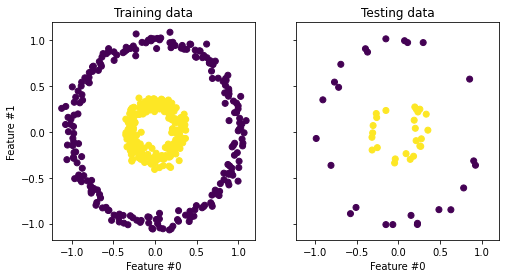

In [ ]:
#plotting the dataset

import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [ ]:
# creating object and fitting the model
model = svm(c=5.0)
model.fit(X_train, y_train)
print(model._weights)
print(model._b)

[-6.44385665  0.65957402]
-3.1317847899781968


weights=[-6.44385665  0.65957402]
b=-3.1317847899781968


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


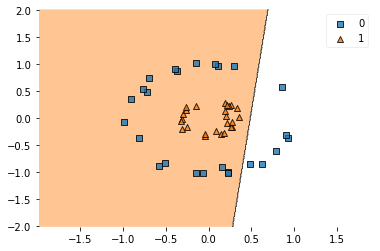

In [ ]:
#printing the weight and bias
print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[-0.02782832  0.00034795]]
intercept=[1.76415657e-05]


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


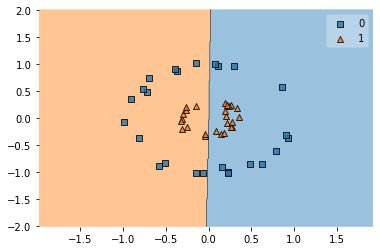

In [ ]:
#linear SVC

from sklearn.svm import LinearSVC


sk_model = LinearSVC()
sk_model.fit(X_train, y_train.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

test score of the model: 1.0


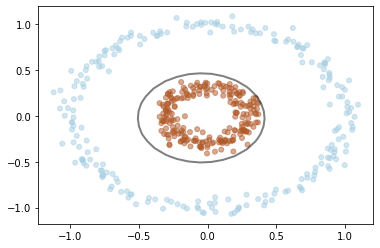

In [ ]:
X, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=0)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

svm_poly_model = svm(kernel='poly',c=1.0)
svm_poly_model.fit(X_train, y_train)
print("test score of the model:", svm_poly_model.score(X_test, y_test))
svm_poly_model.plot_boundary()


In [ ]:
# ##poly SVC

# from sklearn.svm import SVC

# clf = SVC(C=1.0, kernel='poly', degree=3, gamma=2,max_iter = 1e5)
# clf.fit(X_train, y_train.astype(np.int32))
# print(f"coef_={clf.coef_}")
# print(f"intercept={clf.intercept_}")


# fig = plt.figure()
# ax = plot_decision_regions(X_test, y_test.astype(np.int32), clf)
# fig.add_subplot(ax)
# plt.show()

In [ ]:
# IRIS dataset
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = iris["data"]
iris_lables= iris["target"]